When will I win the Great Bear Run?
-----------------------------------------

This notebook presents an application of Bayesian inference to predicting the outcome of a road race.

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [11]:
from __future__ import print_function, division

import thinkbayes2
import thinkplot

import numpy as np
from scipy import stats

%matplotlib inline

In [8]:
data = {
    2008: ['Gardiner', 'McNatt', 'Terry'],
    2009: ['McNatt', 'Ryan', 'Partridge', 'Turner', 'Demers'],
    2010: ['Gardiner', 'Barrett', 'Partridge'],
    2011: ['Barrett', 'Partridge'],
    2012: ['Sager'],
    2013: ['Hammer', 'Wang', 'Hahn'],
    2014: ['Partridge', 'Hughes', 'Smith'],
    2015: ['Barrett', 'Sagar', 'Fernandez'],
}

In [72]:
def MakeBinomialPmf(n, p):
    ks = range(n+1)
    ps = stats.binom.pmf(ks, n, p)
    pmf = thinkbayes2.Pmf(dict(zip(ks, ps)))
    pmf.Normalize()
    return pmf

In [150]:
class Bear1(thinkbayes2.Suite, thinkbayes2.Joint):
    def Likelihood(self, data, hypo):
        n, p = hypo
        like = 1
        for year, sobs in data.items():
            k = len(sobs)
            if k > n:
                return 0
            like *= stats.binom.pmf(k, n, p)
        return like
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for (n, p), prob in bear.Items():
            pmf = MakeBinomialPmf(n, p)
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

In [151]:
hypos = [(n, p) for n in range(16, 70) for p in np.linspace(0, 1, 101)]
bear = Bear1(hypos)

In [152]:
bear.Update(data)

9.7429617466130483e-08

0.048848085866427957

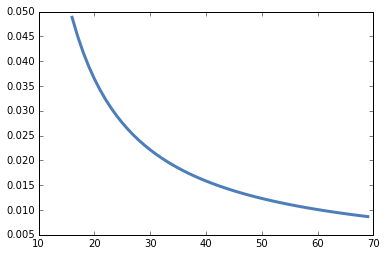

In [158]:
pmf_n = bear.Marginal(0)
thinkplot.Pdf(pmf_n)
pmf_n[16]

0.059999999999999998

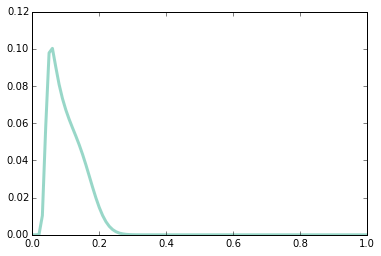

In [161]:
pmf_p = bear.Marginal(1)
thinkplot.Pdf(pmf_p)
pmf_p.MaximumLikelihood()

In [162]:
stats.binom.pmf(0, 16, 0.06)

0.37157429083410093

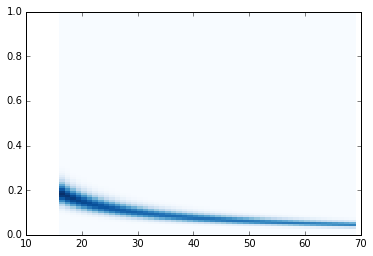

In [155]:
thinkplot.Contour(bear, pcolor=True, contour=False);

0.052046954456205607

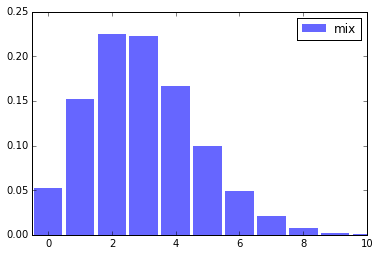

In [164]:
predict = bear.Predict()
thinkplot.Hist(predict)
thinkplot.Config(xlim=[-0.5, 10])
predict[0]

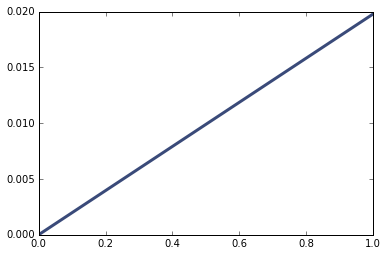

In [166]:
ss = thinkbayes2.Beta(2, 1)
thinkplot.Pdf(ss.MakePmf())

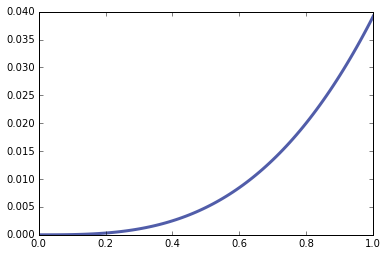

In [199]:
os = thinkbayes2.Beta(4, 1)
thinkplot.Pdf(os.MakePmf())

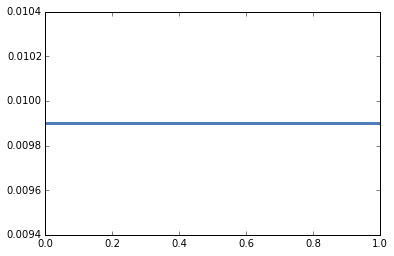

In [200]:
bs = thinkbayes2.Beta(1, 1)
thinkplot.Pdf(bs.MakePmf())

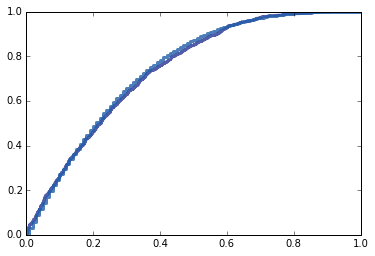

In [204]:
n = 1000
sample = ss.Sample(n) * os.Sample(n) * bs.Sample(n)
cdf = thinkbayes2.Cdf(sample)
thinkplot.Cdf(cdf)

prior = thinkbayes2.Beta(1, 3)
thinkplot.Cdf(prior.MakeCdf());

In [48]:
from itertools import chain
from collections import Counter

counter = Counter(chain(*data.values()))
len(counter), counter

(16,
 Counter({'Partridge': 4, 'Barrett': 3, 'Gardiner': 2, 'McNatt': 2, 'Demers': 1, 'Hughes': 1, 'Hahn': 1, 'Wang': 1, 'Smith': 1, 'Ryan': 1, 'Sager': 1, 'Sagar': 1, 'Terry': 1, 'Turner': 1, 'Hammer': 1, 'Fernandez': 1}))

In [208]:
def MakeBeta(count, num_races, precount=3):
    beta = thinkbayes2.Beta(1, precount)
    beta.Update((count, num_races-count))
    return beta

In [211]:
num_races = len(data)
betas = [MakeBeta(count, num_races) 
         for count in counter.values()]

In [212]:
[beta.Mean() for beta in betas]

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.25,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.25,
 0.16666666666666666,
 0.16666666666666666,
 0.4166666666666667,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.3333333333333333]

In [213]:
class Bear2(thinkbayes2.Suite, thinkbayes2.Joint):

    def ComputePmfs(self, data):
        num_races = len(data)
        counter = Counter(chain(*data.values()))
        betas = [MakeBeta(count, num_races) 
                 for count in counter.values()]
        
        self.pmfs = dict()
        low = len(betas)
        high = max(self.Values())
        for n in range(low, high+1):
            self.pmfs[n] = self.ComputePmf(betas, n, num_races)
    
    def ComputePmf(self, betas, n, num_races):
        no_show = thinkbayes2.Beta(1, num_races+1)
        all_betas = betas + [no_show] * (n - len(betas))
        
        ks = []
        for i in range(1000):
            ps = [beta.Random() for beta in all_betas]
            xs = np.random.random(len(ps))
            k = sum(xs < ps)
            ks.append(k)
            
        return thinkbayes2.Pmf(ks)
    
    def Likelihood(self, data, hypo):
        n = hypo
        k = data
        return self.pmfs[n][k]
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for n, prob in self.Items():
            pmf = bear2.pmfs[n]
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

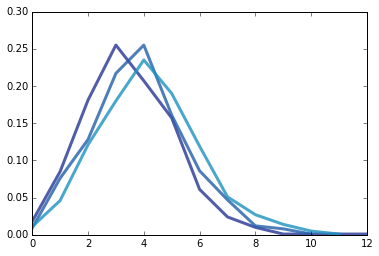

In [222]:
bear2 = Bear2()
pmf = bear2.ComputePmf(betas, 18, num_races)
pmf2 = bear2.ComputePmf(betas, 22, num_races)
pmf3 = bear2.ComputePmf(betas, 26, num_races)
thinkplot.Pdfs([pmf, pmf2, pmf3])

In [223]:
low = 16
high = 35
bear2 = Bear2(range(low, high))
bear2.ComputePmfs(data)

In [224]:
for year, sobs in data.items():
    k = len(sobs)
    bear2.Update(k)

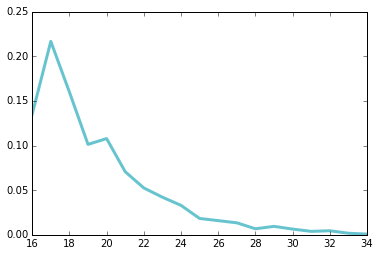

In [225]:
thinkplot.Pdf(bear2)

In [226]:
predict = bear2.Predict()

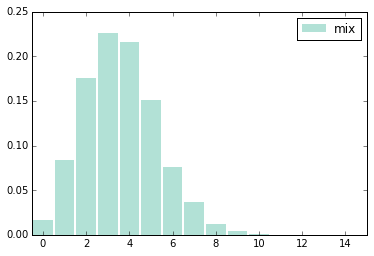

In [227]:
thinkplot.Hist(predict)
thinkplot.Config(xlim=[-0.5, 15])